In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from utils import group_into_trips, group_by_engine_type
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [5]:
static = pd.read_csv('../VED_Static_Data_ICE_HEV.csv')
timeseries = pd.read_csv('../sample_data.csv')
ICEs, _, _, _ = group_by_engine_type(static, timeseries)

In [6]:
trips = group_into_trips(ICEs)

In [7]:
print(trips[2]['Vehicle Speed[km/h]'].head(20))
print(trips[2]['Latitude[deg]'])

1067     0.0
1068     0.0
1069     0.0
1070     0.0
1071     0.0
1072     0.0
1073     0.0
1074     0.0
1075     0.0
1076     0.0
1077     0.0
1078     0.0
1079     0.0
1080    22.0
1081    22.0
1082    24.0
1083    24.0
1084    24.0
1085    26.0
1086    26.0
Name: Vehicle Speed[km/h], dtype: float64
1067    42.243881
1068    42.243881
1069    42.243881
1070    42.243881
1071    42.243881
          ...    
1192    42.232468
1193    42.232468
1194    42.232468
1195    42.232468
1196    42.232468
Name: Latitude[deg], Length: 130, dtype: float64


In [8]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 20)

In [9]:
def velocity_functor():
    '''
    *** Adapted from accel_functor in power_factors.ipynb ***
    
    Return a function object that, when called with a vehicle's speed(km/h), a timestamp (in ms), computes the numerator of the pke formula
    based on the coordinates and vehicle speed of the current timestamp and the parameters from the
    previous call to the function.
    
    Haversine distance is in km.
    
    Using this with Pandas Series objects (where trip is a DataFrame rep. a trip):
    f = distance_functor()
    a = trip.apply(lambda df : f(df['Latitude[deg]'], df[Vehicle Speed[km/h], df['Timestamp(ms)']))
    '''
    
    
    prev_v = None
    prev_t = None
    
    def wrapped(v, t):
        nonlocal  prev_v, prev_t
        delta_v_squared = None
        if prev_v is not None and prev_t is not None:
            #print("V: ", v, " PREV V: ", prev_v)
            delta_v_squared = np.square(v) - np.square(prev_v)
            
        prev_v = v
        prev_t = t
        return delta_v_squared
    
    return wrapped

def distance_functor():
    '''
    Return a function object that, when called with a vehicle's coordinates (Latitude, Longitude in degrees), computes the distance
    traveled based on the coordinates of the current timestamp and the parameters from the previous call to the function.
    
    Calulcates distance using Haversine Formula
    '''
    
    prev_lat = None
    prev_long = None
    
    def wrapped(lat, long):
        nonlocal prev_lat, prev_long
        dist = None
        if prev_lat is not None and prev_long is not None:
            dist = haversine_distance(prev_lat, prev_long, lat, long)
            
        prev_lat = lat
        prev_long = long
        return dist
    return wrapped

def get_v_squared(trip):
    '''
    Given a trip in a Pandas DataFrame, return a Pandas Series that contains velocity squared
    data for the vehicle (in km^2 /hr^2) on that trip.
    '''
    trip.sort_values(by=['Timestamp(ms)'])
    f = velocity_functor()
    return trip.apply(lambda df : f(df['Vehicle Speed[km/h]'], df['Timestamp(ms)']), axis=1)

def get_distances(trip):
    '''
    Given a trip in a Pandas DataFrame, return a Pandas Series that contains distance traveled for each datapoint in the trip.
    Distance is in km.
    '''
    trip.sort_values(by=['Timestamp(ms)'])
    f = distance_functor()
    return trip.apply(lambda df : f(df['Latitude[deg]'], df['Longitude[deg]']), axis=1)
    

def pke(v_squared_values, distance_values):
    '''
    Given a timeseries of velocity squared values as a pandas Series and beginning + end lat/long coordinates, returns PKE value for trip.
    Haversine formula calculates distance between coordinates in km.
    '''
    pos_sum = 0
    dist_traveled = np.sum(distance_values)
    for value in v_squared_values:
        #print("VALUE: ", value)
        if value >= 0:
            pos_sum += value
            
    return pos_sum/dist_traveled

def nke(v_squared_values, distance_values):
    '''
    Given a timeseries of velocity squared values as a pandas Series and beginning + end lat/long coordinates, returns NKE (negative kinetic energy) value for trip.
    Haversine formula calculates distance between coordinates in km.
    '''
    neg_sum = 0
    dist_traveled = np.sum(distance_values)
    for value in v_squared_values:
        if value < 0:
            neg_sum += value
            
    return neg_sum/dist_traveled

def kinetic_energy(v_squared_values, distance_values):
    '''
    Given a timeseries of velocity squared values as a pandas Series and beginning + end lat/long coordinates, returns absolute kinetic energy value for trip.
    Haversine formula calculates distance between coordinates in km.
    '''
    total_energy = 0
    dist_traveled = np.sum(distance_values)
    for value in v_squared_values:
        if not pd.isnull(value):
            total_energy += np.absolute(value)
    return total_energy/dist_traveled


In [10]:
trip = trips[2]
v_squared = get_v_squared(trip)

dist_values = get_distances(trip)

lat_begin = trip.iloc[0]['Latitude[deg]']
long_begin = trip.iloc[0]['Longitude[deg]']

lat_end = trip.iloc[trip.shape[0] - 1]['Latitude[deg]']
long_end = trip.iloc[trip.shape[0] - 1]['Longitude[deg]']

print("data points summed distance of trip", np.sum(dist_values))
print("haversine distance of trip ", haversine_distance(lat_begin, long_begin, lat_end, long_end))
print("calculated PKE of trip: ", pke(v_squared, dist_values))
print("calculated NKE of trip: ", nke(v_squared, dist_values))
print("calculated KE of trip: ", kinetic_energy(v_squared, dist_values))

data points summed distance of trip 1.2735617100918772
haversine distance of trip  1.2693137150462017
calculated PKE of trip:  4804.635654096858
calculated NKE of trip:  -4000.5913805562172
calculated KE of trip:  8805.227034653075


In [11]:
pke_scores = []
nke_scores = []
ke_scores = []
for trip in trips:
    v_squared = get_v_squared(trip)
    dist_values = get_distances(trip)
    
    pke_score = pke(v_squared, dist_values)
    nke_score = nke(v_squared, dist_values)
    ke_score = kinetic_energy(v_squared, dist_values)
    veh_id = trip['VehId'].unique()[0]
    trip_id = trip['Trip'].unique()[0]
    pke_scores.append(pke_score)
    nke_scores.append(nke_score)
    ke_scores.append(ke_score)

    #print(f"Trip with VehId {veh_id} and TripId {trip_id} has PKE score {pke_score}")
    #print(f"Trip with VehId {veh_id} and TripId {trip_id} has NKE score {nke_score}")
    print(f"Trip with VehId {veh_id} and TripId {trip_id} has KE score {ke_score}")

Trip with VehId 12 and TripId 976 has KE score 8355.310505652167
Trip with VehId 463 and TripId 976 has KE score 6020.747693387664
Trip with VehId 12 and TripId 977 has KE score 8805.227034653075
Trip with VehId 12 and TripId 978 has KE score 8035.799246968483
Trip with VehId 12 and TripId 979 has KE score 13171.904995256338
Trip with VehId 463 and TripId 979 has KE score 10283.500334881172
Trip with VehId 12 and TripId 983 has KE score 10647.554476895137
Trip with VehId 108 and TripId 1721 has KE score 13750.74337599726
Trip with VehId 135 and TripId 2242 has KE score 7990.808936376753
Trip with VehId 462 and TripId 2242 has KE score 8247.173604138501
Trip with VehId 135 and TripId 2243 has KE score 7675.0958616613625
Trip with VehId 502 and TripId 2243 has KE score 7906.567406819194
Trip with VehId 145 and TripId 1526 has KE score 9434.66391951111
Trip with VehId 145 and TripId 1532 has KE score 7028.103358181785
Trip with VehId 145 and TripId 1539 has KE score 10046.00132930505
Trip

In [12]:
pke_scores

[4194.91466462615,
 3122.2813460757343,
 4804.635654096858,
 3908.0096653397936,
 6540.799410584725,
 5406.49606638343,
 5112.654350727244,
 6769.596738952497,
 4031.7634279694576,
 4140.068471070604,
 4030.990885654045,
 3511.800244145581,
 3833.6662894901588,
 3523.0436672469204,
 5140.158169253487,
 7789.891252969189,
 7039.469209459945,
 7689.674061562392,
 4009.715596641065,
 5523.407267110763,
 3469.5970626829926,
 4094.0035467596513,
 5180.237000165843,
 4847.81458631318,
 4977.466451512415,
 3936.085458856661,
 5022.819642459711,
 5863.725414066113,
 3371.202311260616,
 2259.714745356738,
 4813.524974773468,
 4089.7916039533566,
 4048.7935039398762,
 7395.468983830565,
 4660.0157960054585,
 3841.411107744797,
 4636.456546778605,
 5856.5039322172,
 5175.981713676027,
 4921.634785881485,
 3406.387035679112,
 7038.816581630148,
 2964.2966451633342,
 4423.3381083606555,
 5234.536982001778,
 5769.77157575716,
 6120.617456402813,
 6367.132662760116,
 4822.80629231643,
 5012.170171403

In [13]:
%store -r aggressive_scores

no stored variable or alias aggressive_scores


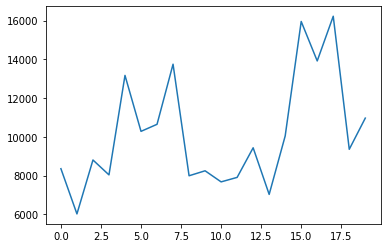

In [14]:
plt.plot(ke_scores[:20])

In [15]:
ke_scores

[8355.310505652167,
 6020.747693387664,
 8805.227034653075,
 8035.799246968483,
 13171.904995256338,
 10283.500334881172,
 10647.554476895137,
 13750.74337599726,
 7990.808936376753,
 8247.173604138501,
 7675.0958616613625,
 7906.567406819194,
 9434.66391951111,
 7028.103358181785,
 10046.00132930505,
 15956.830129657124,
 13919.174978866256,
 16226.65874798403,
 9357.342057630025,
 10966.839664287148,
 6924.181547423972,
 8148.118101337759,
 10102.426665484281,
 10251.38248251467,
 9769.070366493055,
 8223.041109936814,
 10236.879428637994,
 11106.585784289931,
 6928.666421024575,
 4570.793879796868,
 8515.945781070046,
 8319.034114560392,
 7989.667145491307,
 17871.88192186882,
 9887.44657903872,
 7421.632972699142,
 9357.552880884306,
 11990.590606187956,
 9798.292774025282,
 10167.077143364713,
 7354.7321275227,
 13842.942855080102,
 6973.839681998068,
 8948.212730884632,
 10484.697761813759,
 11901.87886190162,
 12393.566587720341,
 11479.196952833776,
 9734.222015809306,
 10188.2